# Panan005 Bottom salinity

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42915/status,
Dashboard: /proxy/42915/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33849,Workers: 28
Dashboard: /proxy/42915/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:39627,Total threads: 1
Dashboard: /proxy/46297/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45583,


In [4]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds['so'].isel(z_l=0).sel(yh=slice(None,-55))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
# Area
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/output120/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

In [10]:
# Salinity variable
saltC = cont['so']
saltM = melt['so']

In [12]:
# Correcting area
var_C = saltC.isel(time=0)
var_M = saltM.isel(time=0)

areaC_corr = areaC*(var_C*0 +1)
areaM_corr = areaM*(var_M*0 +1)

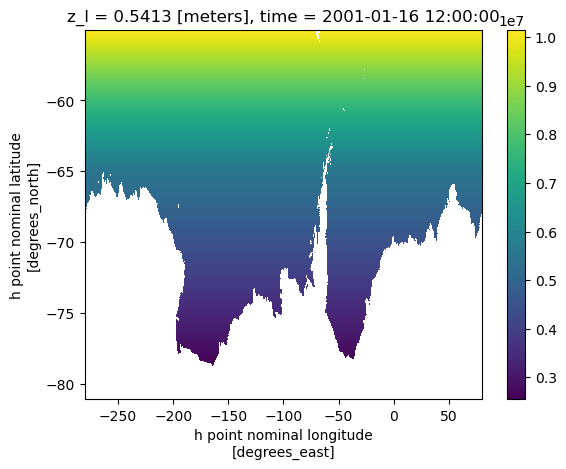

In [13]:
areaC_corr.plot()

## Surface salinity

In [14]:
shelf_salt_cont = saltC.where(shelf_mask == 1)
shelf_salt_pert = saltM.where(shelf_mask == 1)
shelf_salt_cont

<xarray.DataArray 'so' (time: 120, yh: 1066, xh: 7200)> Size: 4GB
dask.array<where, shape=(120, 1066, 7200), dtype=float32, chunksize=(1, 388, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -78.99 -78.96 -78.94 ... -55.08 -55.05 -55.02
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
    z_l      float64 8B 0.5413
Attributes:
    units:          psu
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

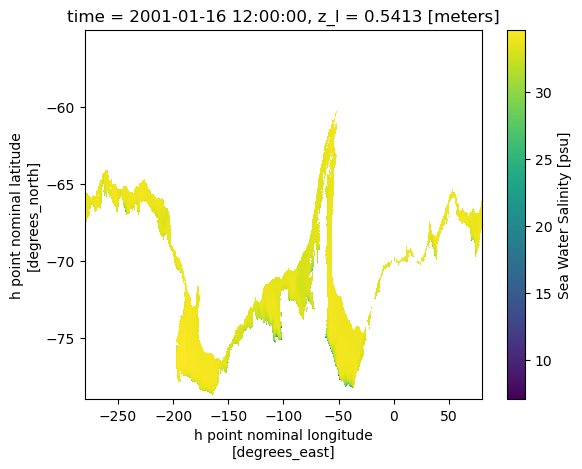

In [15]:
shelf_salt_cont.isel(time=0).plot()

In [16]:
# Spatial average
topsalt_cont_time = (areaC_corr * shelf_salt_cont).sum(['xh', 'yh']) / areaC_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
topsalt_pert_time = (areaM_corr * shelf_salt_pert).sum(['xh', 'yh']) / areaM_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [17]:
topsalt_cont_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [18]:
topsalt_cont_time = topsalt_cont_time.load()

In [19]:
topsalt_pert_time = topsalt_pert_time.load()

Text(0.5, 1.0, 'Pan005 Time Series of Surface Salinity on Shelf')

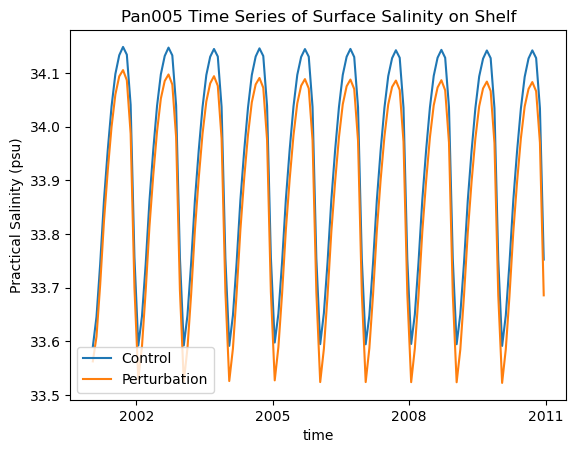

In [21]:
topsalt_cont_time.plot(label="Control")
topsalt_pert_time.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Practical Salinity (psu)")
plt.legend(loc="lower left")
plt.title("Pan005 Time Series of Surface Salinity on Shelf")

In [22]:
topsalt_anom_time = topsalt_pert_time - topsalt_cont_time
topsalt_anom_time = topsalt_anom_time.load()

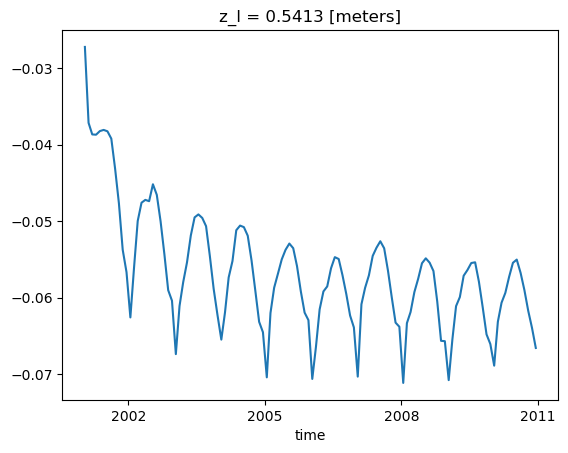

In [23]:
topsalt_anom_time.plot()

In [24]:
topsalt_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_pan005.nc')

#### Time series

In [25]:
saltC_map = saltC.sel(time=slice('2006-01-01','2010-12-31'))
saltM_map = saltM.sel(time=slice('2006-01-01','2010-12-31'))

In [26]:
saltC_map

<xarray.DataArray 'so' (time: 60, yh: 1166, xh: 7200)> Size: 2GB
dask.array<getitem, shape=(60, 1166, 7200), dtype=float32, chunksize=(1, 564, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -81.1 -81.08 -81.06 ... -55.08 -55.05 -55.02
    z_l      float64 8B 0.5413
  * time     (time) object 480B 2006-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          psu
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [27]:
topsalt_cont_map = saltC_map.mean(dim='time')
topsalt_pert_map = saltM_map.mean(dim='time')
topsalt_anom_map = topsalt_pert_map - topsalt_cont_map

In [28]:
topsalt_anom_map = topsalt_anom_map.load()

In [29]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

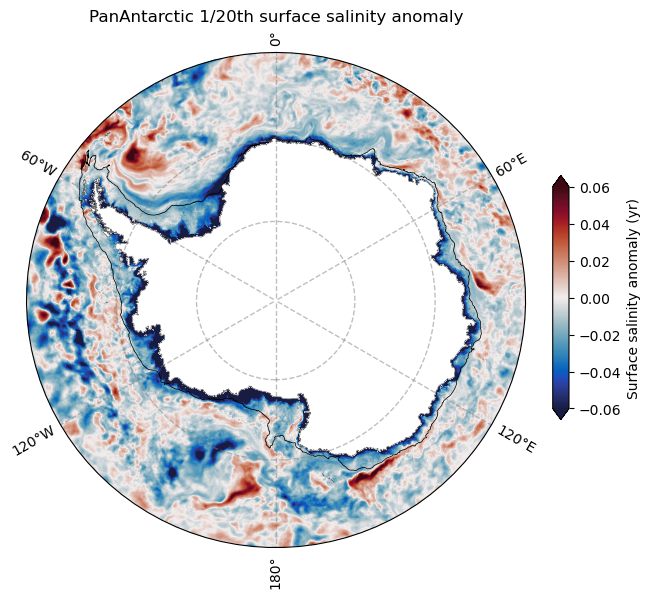

In [30]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
topsalt_anom_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Surface salinity anomaly (yr)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/20th surface salinity anomaly");

## Comparing between models

haven't renamed but these are surface salt files

In [4]:
pan01_topsalt_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_pan01.nc', chunks = 'auto') # updated
pan005_topsalt_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_pan005.nc', chunks = 'auto') # updated
#acc_botsalt_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_access.nc', chunks = 'auto') 

In [5]:
pan01_topsalt_anom_new = pan01_topsalt_anom.to_series()
pan005_topsalt_anom_new = pan005_topsalt_anom.to_series()
#acc_botsalt_new = acc_botsalt_anom.to_series()

In [6]:
import pandas as pd

In [7]:
# Slice 1910–1919 and 2001–2010
pan01_topsalt_anom_new = pan01_topsalt_anom_new['2001-01-01':'2010-10-16']
pan005_topsalt_anom_new = pan005_topsalt_anom_new['2001-01-01':'2010-10-16']
#acc_botsalt_new = acc_botsalt_new['1910-01-01':'1919-10-16']

# Reset index to normalized months
pan01_topsalt_anom_new.index = range(0, len(pan01_topsalt_anom_new))
pan005_topsalt_anom_new.index = range(0, len(pan005_topsalt_anom_new))
#acc_botsalt_new.index = range(1, len(acc_botsalt_new)+1)

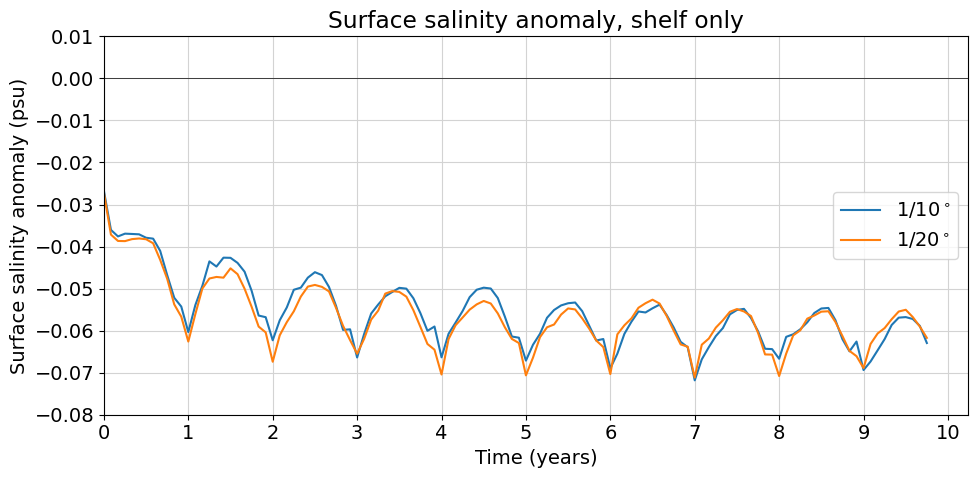

In [10]:
plt.rcParams['font.size'] = 14

# Make month index start at 0
pan01_topsalt_anom_new.index = range(len(pan01_topsalt_anom_new))
pan005_topsalt_anom_new.index = range(len(pan005_topsalt_anom_new))

plt.figure(figsize=(10, 5))
plt.plot(pan01_topsalt_anom_new.index, pan01_topsalt_anom_new.values, label='1/10$^\circ$')
plt.plot(pan005_topsalt_anom_new.index, pan005_topsalt_anom_new.values, label='1/20$^\circ$')

# X-axis: ticks every 12 months, labeled as years from 0 to 10
plt.xticks(ticks=range(0, 121, 12), labels=[str(i) for i in range(0, 11)])

plt.xlabel('Time (years)')
plt.ylabel("Surface salinity anomaly (psu)")
plt.title('Surface salinity anomaly, shelf only')
plt.ylim(-0.08, 0.01)
plt.xlim(0,None)
plt.legend()
plt.grid(True, color='lightgrey')
plt.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

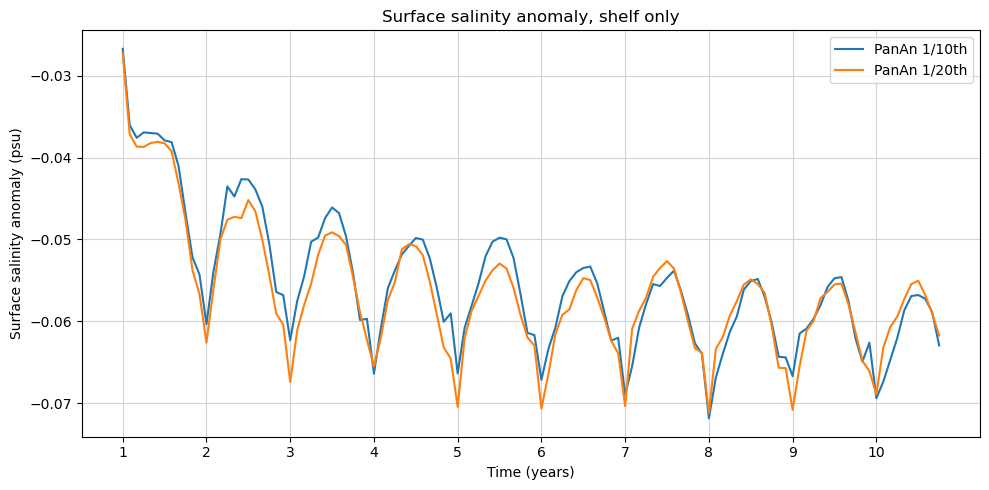

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(pan01_botsalt_anom_new.index, pan01_botsalt_anom_new.values, label='PanAn 1/10th')
plt.plot(pan005_botsalt_anom_new.index, pan005_botsalt_anom_new.values, label='PanAn 1/20th')
#plt.plot(acc_botsalt_new.index, acc_botsalt_new.values, label='ACCESS-OM2')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(1, 11)])

# Labeling and formatting
plt.xlabel('Time (years)')
plt.ylabel("Surface salinity anomaly (psu)")
plt.title('Surface salinity anomaly, shelf only')
plt.legend()
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()